# Lab 3: Classification (Part 2) and Model Selection

## Name: Umang Chavan (uchavan2)

### Due September 20, 2017 12:00 AM [ This is when Wednesday transitions to Thursday. ]

**Logistics and Lab Sumission**

See the [course website](https://courses.engr.illinois.edu/ece398bd/logisticsvvv.html). Remember that all labs count equally, despite the labs being graded from a different number of total points).

**What You Will Need To Know For This Lab**

This lab covers a few more basic classifiers which can be used for M-ary classification:
- Naive Bayes
- Logistic Regression
- Support Vector Machines

as well as cross-validation, a tool for model selection and assessment.
 
There are some problems which have short answer questions. Do not write an essay -- a few sentences will suffice.

Be clear about your answers. For example, if a question asks you "Which classifier would you choose?", be unequivocal about which classifier you would choose (and why); as engineers, part of your job is to make design decisions and justify them in the context of the alternatives and in the application. 

Remember in many applications, the end goal is not always "run a classifier", like in a homework problem, but is to use the output of the classifier in the context of the problem at hand (e.g. detecting spam, identifying cancer, etc.). Because of this, some of our Engineering Design-type questions are designed to get you to think about the entire design problem at a high level.


**Warning: Do not train on your test sets. You will automatically have your score halved for a problem if you train on your test data.**

**Preamble (don't change this)**

In [1]:
from __future__ import division
%pylab inline
import numpy as np
from sklearn import neighbors
from sklearn import svm
from sklearn import cross_validation
from numpy import genfromtxt
from sklearn.preprocessing import MinMaxScaler
import glob

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Problem 1: Spam Detection (70 points)

In this problem, you will be constructing a crude spam detector. As you all know, when you receive an e-mail, it can be divided into one of two types: ham (useful mail, label $-1$) and spam (junk mail, label $+1$). In the [olden days](http://www.paulgraham.com/spam.html), people tried writing a bunch of rules to detect spam. However, it was quickly seen that machine learning approaches work fairly well for a little bit of work. 

You will be designing a spam detector by applying some of the classification techniques you learned in class to a batch of emails used to train and test [SpamAssassin](http://spamassassin.apache.org/), a leading anti-spam software package. 

Let the *vocabulary* of a dataset be a list of all terms occuring in a data set. So, for example, a vocabulary could be ["cat","dog","chupacabra", "aerospace", ...]. 

Our features will be based only the frequencies of terms in our vocabulary occuring in the e-mails (such an approach is called a *bag of words* approach, since we ignore the positions of the terms in the emails). The $j$-th feature is the number of times term $j$ in the vocabulary occurs in the email. If you are interested in further details on this model, you can see Chapters 6 and 13 in [Manning's Book](http://nlp.stanford.edu/IR-book/).

You will use the following classifiers in this problem:
- sklearn.naive_bayes.BernoulliNB (Naive Bayes Classifier with Bernoulli Model)
- sklearn.naive_bayes.MultinomialNB (Naive Bayes Classifier with Multinomial Model)
- sklearn.svm.LinearSVC (Linear Support Vector Machine)
- sklearn.linear_model.LogisticRegression (Logistic Regression)
- sklearn.neighbors.KNeighborsClassifier (1-Nearest Neighbor Classifier)

In the context of the Bernoulli Model for Naive Bayes, scikit-learn will binarize the features by interpretting the $j$-th feature to be $1$ if the $j$-th term in the vocabulary occurs in the email and $0$ otherwise. This is a categorical Naive Bayes model, with binary features. While we did not discuss the multinomial model in class, it operates directly on the frequencies of terms in the vocabulary, and is discussed in Section 13.2 in [Manning's Book](http://nlp.stanford.edu/IR-book/) (though you do not need to read this reference). Both the Bernoulli and Multinomial models are commonly used for Naive Bayes in text classification. 

A sample Ham email is:

    From nic@starflung.com  Mon Jun 24 17:06:54 2002
    Return-Path: 7910726.0.27May2002215326@mp.opensrs.net
    Delivery-Date: Tue May 28 02:53:28 2002
    Received: from mp.opensrs.net (mp.opensrs.net [216.40.33.45]) by
        dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g4S1rSe14718 for
        <zzz@spamassassin.taint.org>; Tue, 28 May 2002 02:53:28 +0100
    Received: (from popensrs@localhost) by mp.opensrs.net (8.9.3/8.9.3) id
        VAA04361; Mon, 27 May 2002 21:53:26 -0400
    Message-Id: <7910726.0.27May2002215326@mp.opensrs.net>
    Date: Mon, 27 May 2002 21:53:26 -0500 (EST)
    From: "Starflung NIC" <nic@starflung.com>
    To: <zzz@spamassassin.taint.org>
    Subject: Automated 30 day renewal reminder 2002-05-27
    X-Keywords: 

    The following domains that are registered as belonging
    to you are due to expire within the next 60 days. If
    you would like to renew them, please contact
    nic@starflung.com; otherwise they will be deactivated
    and may be registered by another.


    Domain Name, Expiry Date
    nutmegclothing.com, 2002-06-26
    
    
A sample Spam email is: 

    From jjj@mymail.dk  Fri Aug 23 11:03:31 2002
    Return-Path: <jjj@mymail.dk>
    Delivered-To: zzzz@localhost.example.com
    Received: from localhost (localhost [127.0.0.1])
        by phobos.labs.example.com (Postfix) with ESMTP id 478B54415C
        for <zzzz@localhost>; Fri, 23 Aug 2002 06:02:57 -0400 (EDT)
    Received: from mail.webnote.net [193.120.211.219]
        by localhost with POP3 (fetchmail-5.9.0)
        for zzzz@localhost (single-drop); Fri, 23 Aug 2002 11:02:57 +0100 (IST)
    Received: from smtp.easydns.com (smtp.easydns.com [205.210.42.30])
        by webnote.net (8.9.3/8.9.3) with ESMTP id IAA08912;
        Fri, 23 Aug 2002 08:13:36 +0100
    From: jjj@mymail.dk
    Received: from mymail.dk (unknown [61.97.34.233])
        by smtp.easydns.com (Postfix) with SMTP
        id 7484A2F85C; Fri, 23 Aug 2002 03:13:31 -0400 (EDT)
    Reply-To: <jjj@mymail.dk>
    Message-ID: <008c61d64eed$6184e5d5$4bc22de3@udnugg>
    To: bbr_hooten@yahoo.com
    Subject: HELP WANTED.  WORK FROM HOME REPS.
    MiME-Version: 1.0
    Content-Type: text/plain;
        charset="iso-8859-1"
    X-Priority: 3 (Normal)
    X-MSMail-Priority: Normal
    X-Mailer: Microsoft Outlook, Build 10.0.2616
    Importance: Normal
    Date: Fri, 23 Aug 2002 03:13:31 -0400 (EDT)
    Content-Transfer-Encoding: 8bit

    Help wanted.  We are a 14 year old fortune 500 company, that is
    growing at a tremendous rate.  We are looking for individuals who
    want to work from home.

    This is an opportunity to make an excellent income.  No experience
    is required.  We will train you.

    So if you are looking to be employed from home with a career that has
    vast opportunities, then go:

    http://www.basetel.com/wealthnow

    We are looking for energetic and self motivated people.  If that is you
    than click on the link and fill out the form, and one of our
    employement specialist will contact you.

    To be removed from our link simple go to:

    http://www.basetel.com/remove.html


    1349lmrd5-948HyhJ3622xXiM0-290VZdq6044fFvN0-799hUsU07l50



First, we will load the [data](http://spamassassin.apache.org/publiccorpus/readme.html). Our dataset has a bit over 9000 emails, with about 25% of them being spam. We will use 50% of them as a training set, 25% of them as a validation set and 25% of them as a test set. 

In [2]:
# Get list of emails
spamfiles=glob.glob('./Data/Spam/*')
hamfiles=glob.glob('./Data/Ham/*')

In [3]:
# First, we will split the files into the training, validation and test sets.

np.random.seed(seed=222017) # seed the RNG for repeatability

fnames=np.asarray(spamfiles+hamfiles)
nfiles=fnames.size
labels=np.ones(nfiles)
labels[len(spamfiles):]=-1

# Randomly permute the files we have
idx=np.random.permutation(nfiles)
fnames=fnames[idx]
labels=labels[idx]

#Split the file names into which set they belong to
tname=fnames[:int(nfiles/2)]
trainlabels=labels[:int(nfiles/2)]
vname=fnames[int(nfiles/2):int(nfiles*3/4)]
vallabels=labels[int(nfiles/2):int(nfiles*3/4)]
tename=fnames[int(3/4*nfiles):]
testlabels=labels[int(3/4*nfiles):]

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

# Get our Bag of Words Features from the data
bow = CountVectorizer(input='filename',encoding='iso-8859-1',binary=False)
traindata=bow.fit_transform(tname)
valdata=bow.transform(vname)
testdata=bow.transform(tename)

The $100$ most and least common terms in the vocabulary are:

In [5]:
counts=np.reshape(np.asarray(np.argsort(traindata.sum(axis=0))),-1)
vocab=np.reshape(np.asarray(bow.get_feature_names()),-1)
print "100 most common terms: " , ','.join(str(s) for s in vocab[counts[-100:]]), "\n"
print "100 least common terms: " , ','.join(str(s) for s in vocab[counts[:100]])

100 most common terms:  mail,tue,not,have,click,as,ist,thu,wed,jmason,request,or,lists,cnet,are,html,mon,exmh,00,arial,date,12,users,align,message,mailman,freshrpms,text,postfix,ie,type,bgcolor,linux,rpm,version,your,be,taint,22,mailto,color,20,admin,content,table,sourceforge,jm,face,on,nbsp,border,href,aug,127,example,gif,this,10,img,src,subject,09,sep,it,0100,that,height,spamassassin,size,esmtp,is,you,xent,fork,www,tr,in,list,11,br,width,received,localhost,of,id,org,and,by,with,net,for,font,td,http,2002,from,3d,the,to,com 

100 least common terms:  g7t9rkj15284,gpgkeyothermethod,gpghkpkeyserverurl,gpgdigestmods,gpgdigestalgo,gpgcompressalgo,gpgcomment,gpgciphermods,gpgkeyquerymethod,gpgcipheralgo,gpgcacheids,gpgautoextract,gp1cfwwwprdeb5ycvh3vhe9lysibeuqwq4mgveascl7aayjwf,gowfeo77qp1,gouvernement,gourley,gouging,gpgchoosekey,goufha5xiow78sa4,gpgkeyserver,gpgminmatch,gpsyia6kj47l6de,gpsmccnk3iccrhgaaicffcggqhefxuflonq4r84aknimjf9nldmbbd0iwem,gprbhrob22o,gpr7kqmmt48wbmaea8,gpoulose,gpn

We will have our training data in `traindata` (with labels in `trainlabels`), validation data in `valdata` (with labels in `vallabels`) and test data in `testdata` (with labels in `testlabels`). The data is stored as a sparse scipy matrix (scipy.sparse.csr.csr_matrix), since we have a decent number of features (~100k), most of which are zero (~0.2% are non-zero), this allows storing the data in a few megabytes. Directly storing it as a numpy array (as we did in lab 1) would take around 8 gigabytes. Working with sparse data can make many algorithms run faster and use less storage. 

Train each of the following classifiers **( 3 Points Each )**:
- sklearn.naive_bayes.BernoulliNB (Naive Bayes Classifier with Bernoulli Model)
- sklearn.naive_bayes.MultinomialNB (Naive Bayes Classifier with Multinomial Model)
- sklearn.svm.LinearSVC (Linear Support Vector Machine)
- sklearn.linear_model.LogisticRegression (Logistic Regression)
- sklearn.neighbors.KNeighborsClassifier (as a 1-Nearest Neighbor Classifier)
on the training data in `traindata` with corresponding labels `trainlabels`. Use the default parameters, unless otherwise noted.

For each classifier, report:
- Time it took to fit the classifier (i.e. call the .fit method) **(1 Point Each)**
- Training Error **( 1 Point Each)**

This part of the problem has a total of **15 points**.

In [6]:
from sklearn.naive_bayes import BernoulliNB 
from sklearn.naive_bayes import MultinomialNB 
from sklearn.svm import LinearSVC 
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC

In [7]:
def classifierError(truelabels, estimatedlabels):
    count=0
    for i in range(truelabels.shape[0]):
        if truelabels[i] != estimatedlabels[i]:
            count += 1
    
    return count/len(estimatedlabels)


In [8]:
# Put your code here
import time
#######################################

# Bernoulli

Bern = BernoulliNB()
start_time = time.clock()
neighbor = Bern.fit(traindata, trainlabels)
t_time = time.clock() - start_time
NBtrainlabels = neighbor.predict(traindata)


print "Runtime to fit Bernoulli: ", t_time
print "Classifier error for Bernoulli: ", classifierError(trainlabels, NBtrainlabels)

########################################

# Multinomial

Mult = MultinomialNB()
start_time = time.clock()
neighbor = Mult.fit(traindata, trainlabels)
t_time = time.clock() - start_time
MBtrainlabels = neighbor.predict(traindata)

print "Runtime to fit Multinomial: ", t_time
print "Classifier error for Multinomial: ", classifierError(trainlabels, MBtrainlabels)

########################################

# Linear SVC

Lin = LinearSVC()
start_time = time.clock()
neighbor = Lin.fit(traindata, trainlabels)
t_time = time.clock() - start_time
SVMtrainlabels = neighbor.predict(traindata)

print "Runtime to fit Linear SVC: ", t_time
print "Classifier error for Linear SVC: ", classifierError(trainlabels, SVMtrainlabels)

########################################

# Logistic Regression

LogR = LogisticRegression()
start_time = time.clock()
neighbor = LogR.fit(traindata, trainlabels)
t_time - time.clock() - start_time
LRtrainlabels = neighbor.predict(traindata)

print "Runtime to fit Logistic Regression: ", t_time
print "Classifier error for Logistic Regression: ", classifierError(trainlabels, LRtrainlabels)

########################################

# K Neighbors Classifier

kNN = KNeighborsClassifier(n_neighbors=1)
start_time = time.clock()
neighbor = kNN.fit(traindata, trainlabels)
t_time = time.clock() - start_time
NNtrainlabels = neighbor.predict(traindata)

print "Runtime to fit K Neighbors Classifier (1 neighbor): ", t_time
print "Classifier error for K Neighbors Classifier (1 neighbor): ", classifierError(trainlabels,NNtrainlabels)

########################################

Runtime to fit Bernoulli:  0.046966
Classifier error for Bernoulli:  0.0472828412495
Runtime to fit Multinomial:  0.03624
Classifier error for Multinomial:  0.0181857081729
Runtime to fit Linear SVC:  0.735213
Classifier error for Linear SVC:  0.0
Runtime to fit Logistic Regression:  0.735213
Classifier error for Logistic Regression:  0.0
Runtime to fit K Neighbors Classifier (1 neighbor):  0.002851
Classifier error for K Neighbors Classifier (1 neighbor):  0.0


Give a justification as to why the Linear SVM and Logistic regression have their particular value of training error. **(5 points)**

This is because both models have linear decision boundaries. Therefore, one part of the data is on one side and the other part of the data is on the other side.

Run each of the classifiers on the validation data **(2 Points Each)**:
- sklearn.naive_bayes.BernoulliNB (Naive Bayes Classifier with Bernoulli Model)
- sklearn.naive_bayes.BernoulliNB (Naive Bayes Classifier with Multiomial Model)
- sklearn.svm.LinearSVC (Linear Support Vector Machine)
- sklearn.linear_model.LogisticRegression (Logistic Regression)
- sklearn.neighbors.KNeighborsClassifier (as a 1-Nearest Neighbor Classifier)
on the training data in `traindata` with corresponding labels `trainlabels`. Use the default parameters, unless otherwise noted.

For each classifier:
- Store the labels it predicted as \_\_vallabels, where \_\_ is NB,MB,SVM,LR,NN respectively. **( 1 Point Each)**
- Time it took to run the classifier on the data **(1 Point Each)**
- Validation Error **(1 Point Each)**

This part of the problem has a total of **15 points**.

In [9]:
# Put your code here
import time
#######################################

# Bernoulli

Bern = BernoulliNB()
start_time = time.clock()
neighbor = Bern.fit(traindata, trainlabels)
t_time = time.clock() - start_time
NBvallabels = neighbor.predict(valdata)


print "Runtime to fit Bernoulli: ", t_time
print "Classifier error for Bernoulli: ", classifierError(vallabels, NBvallabels)

########################################

# Multinomial

Mult = MultinomialNB()
start_time = time.clock()
neighbor = Mult.fit(traindata, trainlabels)
t_time = time.clock() - start_time
MBvallabels = neighbor.predict(valdata)

print "Runtime to fit Multinomial: ", t_time
print "Classifier error for Multinomial: ", classifierError(vallabels, MBvallabels)

########################################

# Linear SVC

Lin = LinearSVC()
start_time = time.clock()
neighbor = Lin.fit(traindata, trainlabels)
t_time = time.clock() - start_time
SVMvallabels = neighbor.predict(valdata)

print "Runtime to fit Linear SVC: ", t_time
print "Classifier error for Linear SVC: ", classifierError(vallabels, SVMvallabels)

########################################

# Logistic Regression

LogR = LogisticRegression()
start_time = time.clock()
neighbor = LogR.fit(traindata, trainlabels)
t_time - time.clock() - start_time
LRvallabels = neighbor.predict(valdata)

print "Runtime to fit Logistic Regression: ", t_time
print "Classifier error for Logistic Regression: ", classifierError(vallabels, LRvallabels)

########################################

# K Neighbors Classifier

kNN = KNeighborsClassifier(n_neighbors=1)
start_time = time.clock()
neighbor = kNN.fit(traindata, trainlabels)
t_time = time.clock() - start_time
NNvallabels = neighbor.predict(valdata)

print "Runtime to fit K Neighbors Classifier (1 neighbor): ", t_time
print "Classifier error for K Neighbors Classifier (1 neighbor): ", classifierError(vallabels,NNvallabels)

########################################

Runtime to fit Bernoulli:  0.029346
Classifier error for Bernoulli:  0.0881471972614
Runtime to fit Multinomial:  0.021645
Classifier error for Multinomial:  0.0295250320924
Runtime to fit Linear SVC:  0.693277
Classifier error for Linear SVC:  0.00941377834831
Runtime to fit Logistic Regression:  0.693277
Classifier error for Logistic Regression:  0.00898587933248
Runtime to fit K Neighbors Classifier (1 neighbor):  0.002794
Classifier error for K Neighbors Classifier (1 neighbor):  0.0166880616175


Let us take a more nuanced look at the type of errors made on a data set. The following function calculates a confusion matrix (Fig. 2.1 in the notes) and some statistics. You may wish to read Section 2.1.1 in the notes -- it may be helpful, but is not necessary to complete this problem.

In [10]:
def ConfMatr(truelabels,estimatedlabels,classifiername):
    # classifiername is a string, such as 'Naive Bayes (Bernoulli)'
    cm=np.zeros((2,2))
    cm[0,0]=np.sum(np.logical_and(truelabels==1,estimatedlabels==1)) # True Positives
    cm[0,1]=np.sum(np.logical_and(truelabels==-1,estimatedlabels==1)) # False Positive
    cm[1,0]=np.sum(np.logical_and(truelabels==1,estimatedlabels==-1)) # False Negative
    cm[1,1]=np.sum(np.logical_and(truelabels==-1,estimatedlabels==-1)) # True Negatives
    print "Classifier Name: %s"% classifiername 
    print "True Positives:", cm[0,0], "False Positive:", cm[0,1]
    print "False Negative:", cm[1,0], "True Negatives:", cm[1,1]
    print "True Positive Rate : ", cm[0,0]/np.sum(truelabels==1)
    print "False Positive Rate: ", cm[0,1]/np.sum(truelabels==-1)
    print "---"

Run ConfMatr using the validation labels and their estimates for all the classifiers we've used in this problem. **(5 points)**

In [11]:
# Put your code here
classifierList = ['Naive Bayes (Bernoulli)', 'Naive Bayes (Multinomial)', 'Linear Support Vector Machine', 'Logistic Regression', 'KNeighborsClassifier']

ConfMatr(vallabels, NBvallabels, classifierList[0])
ConfMatr(vallabels, MBvallabels, classifierList[1])
ConfMatr(vallabels, SVMvallabels, classifierList[2])
ConfMatr(vallabels, LRvallabels, classifierList[3])
ConfMatr(vallabels, NNvallabels, classifierList[4])


Classifier Name: Naive Bayes (Bernoulli)
True Positives: 406.0 False Positive: 10.0
False Negative: 196.0 True Negatives: 1725.0
True Positive Rate :  0.674418604651
False Positive Rate:  0.00576368876081
---
Classifier Name: Naive Bayes (Multinomial)
True Positives: 542.0 False Positive: 9.0
False Negative: 60.0 True Negatives: 1726.0
True Positive Rate :  0.900332225914
False Positive Rate:  0.00518731988473
---
Classifier Name: Linear Support Vector Machine
True Positives: 588.0 False Positive: 8.0
False Negative: 14.0 True Negatives: 1727.0
True Positive Rate :  0.976744186047
False Positive Rate:  0.00461095100865
---
Classifier Name: Logistic Regression
True Positives: 589.0 False Positive: 8.0
False Negative: 13.0 True Negatives: 1727.0
True Positive Rate :  0.978405315615
False Positive Rate:  0.00461095100865
---
Classifier Name: KNeighborsClassifier
True Positives: 580.0 False Positive: 17.0
False Negative: 22.0 True Negatives: 1718.0
True Positive Rate :  0.963455149502
Fals

What does the True Positive Rate mean for this problem? What does the False Positive Rate mean for this problem? Do we want these quantites to be high, low or don't care? Explain using words (no equations!). **(10 point)**

In the case of this problem, the True Positive Rate means the percentage of emails classified as Spam that are actually Spam. False Positive Rate for this problem means the percentage of emails classified as Spam that are not actually Spam. We want the True Positive Rate to be high and the False Positive Rate to be low so that we have a pretty accurate classification.

Based on the results of this problem and knowledge of the application at hand (spam filtering), pick one of the classifiers in this problem and describe how you would use it as part of a spam filter for the University of Illinois email system. 

Be sure to justify your choice. **(10 points)**

For this problem, just sketch out a system design at a very high level -- how you would train the spam filter to deal with new threats, would you filter everyone's email jointly, etc. We're just looking for around a paragraph on how you would come up with a (very rough) engineering design using the results of this problem. You may get some inspiration from the [girls and boys](https://gmail.googleblog.com/2007/10/how-our-spam-filter-works.html) at [Gmail](https://gmail.googleblog.com/2015/07/the-mail-you-want-not-spam-you-dont.html), the [chimps at MailChimp](http://kb.mailchimp.com/delivery/spam-filters/about-spam-filters) or other places. Your answer should also include techniques you could use to improve the performance of the classifier over the baseline provided in this problem (e.g. new features, or whatever).

I would choose the Logistic Regression classifier since it has the highest True Positive Rate, giving me the best chance of accurately identifying spam. I think one of the better ways of identifying spam is to continously train the classifier to accept new keywords associated with spam. Along with new keywords, I believe that new features to represent categories would lead to more distinct divisions. This would lead to less variance and flexibility in terms of emails that can be accepted.

Run the classifier you selected in the previous part of the problem on the test data, and display test error and output of ConfMatr. Comment on the true/false positive rate and error as compared to that on the validation set. **(10 points)**

In [12]:
# Put your code here
LogR = LogisticRegression()
neighbor = LogR.fit(testdata, testlabels)
LRtestlabels = neighbor.predict(testdata)

ConfMatr(testlabels, LRtestlabels, 'Logistic Regression on test data ')

Classifier Name: Logistic Regression on test data 
True Positives: 620.0 False Positive: 0.0
False Negative: 0.0 True Negatives: 1718.0
True Positive Rate :  1.0
False Positive Rate:  0.0
---


The True Positive Rate is 100%, which means that every single email that was labelled spam was correctly classified as spam in our scenario. This is a better output than that of the validation set, because the True Positive Rate for the validation set did not guarantee that all "Spam" emails were correctly classified.

### Problem 2: Cross-Validation (50 Points)

Write a function which implements $5$-fold cross-validation to estimate the error of a classifier with cross-validation with the 0,1-loss for k-Nearest Neighbors (kNN). 

You will be given as input:
* A (N,d) numpy.ndarray of training data, trainData (with N divisible by 5)
* A length $N$ numpy.ndarray of training labels, trainLabels
* A number $k$, for which cross-validated error estimates will be outputted for $1,\ldots,k$

Your output will be a vector (represented as a numpy.ndarray) err, such that err[i] is the cross-validated estimate of using i neighbors (err will be of length $k+1$; the zero-th component of the vector will be meaningless). 

So that this problem is easier to grade, take your folds to be 0:N/5, N/5:2N/5, ..., 4N/5:N for cross-validation (In general, the folds should be randomly divided).

Use scikit-learn's sklearn.neighbors.KNeighborsClassifier to perform the training and classification for the kNN models involved. Do not use any other features of scikit-learn, such as things from sklearn.cross_validation. <b>(20 points)</b>

In [93]:
def crossValidationkNN(trainData,trainLabels,k):
    #Put your code here
    N = trainLabels.shape[0]
    
    div1 = N//5
    div2 = 2*N//5
    div3 = 3*N//5
    div4 = 4*N//5
    
    cvDatarr1 = np.array([trainData[div1:div2], trainData[div2:div3], trainData[div3:div4], traindata[div4:N]])
    cvDatarr1 = np.reshape(cvDatarr1, (160,2))
    cvDatarr2 = np.array([trainData[0:div1], trainData[div2:div3], trainData[div3:div4], trainData[div4:N]])
    cvDatarr2 = np.reshape(cvDatarr2, (160,2))
    cvDatarr3 = np.array([trainData[0:div1], trainData[div1:div2], trainData[div3:div4], trainData[div4:N]])
    cvDatarr3 = np.reshape(cvDatarr3, (160,2))
    cvDatarr4 = np.array([trainData[0:div1], trainData[div1:div2], trainData[div2:div3], trainData[div4:N]])
    cvDatarr4 = np.reshape(cvDatarr4, (160,2))
    cvDatarr5 = np.array([trainData[0:div1], trainData[div1:div2], trainData[div2:div3], trainData[div3:div4]])
    cvDatarr5 = np.reshape(cvDatarr5, (160,2))
    
    combDatarr = np.array([cvDatarr1, cvDatarr2, cvDatarr3, cvDatarr4, cvDatarr5])
    
    train_data_vec = np.array([trainData[0:div1], trainData[div1:div2], trainData[div2:div3], trainData[div3:div4], trainData[div4:N]])
    
    cvLabarr1 = np.array([trainLabels[div1:div2], trainLabels[div2:div3], trainLabels[div3:div4], trainLabels[div4:N]])
    cvLabarr1 = np.reshape(cvLabarr1, (160,))
    cvLabarr2 = np.array([trainLabels[0:div1], trainLabels[div2:div3], trainLabels[div3:div4], trainLabels[div4:N]])
    cvLabarr2 = np.reshape(cvLabarr2, (160,))
    cvLabarr3 = np.array([trainLabels[0:div1], trainLabels[div1:div2], trainLabels[div3:div4], trainLabels[div4:N]])
    cvLabarr3 = np.reshape(cvLabarr3, (160,))
    cvLabarr4 = np.array([trainLabels[0:div1], trainLabels[div1:div2], trainLabels[div2:div3], trainLabels[div4:N]])
    cvLabarr4 = np.reshape(cvLabarr4, (160,))
    cvLabarr5 = np.array([trainLabels[0:div1], trainLabels[div1:div2], trainLabels[div2:div3], trainLabels[div3:div4]])
    cvLabarr5 = np.reshape(cvLabarr5, (160,))
    
    combLabarr = np.array([cvLabarr1, cvLabarr2, cvLabarr3, cvLabarr4, cvLabarr5])
    
    train_labels_vec = np.array([trainLabels[0:div1], trainLabels[div1:div2], trainLabels[div2:div3], trainLabels[div3:div4], trainLabels[div4:N]])
    
    
    
    
    error = np.zeros(k+1)

    
    for i in range(1,k+1):
        kNN = KNeighborsClassifier(n_neighbors = i)
        errSum = 0
        for j in range(5):
            kNN_neighbor = kNN.fit(combDatarr[j], combLabarr[j])
            estValLabels = kNN_neighbor.predict(train_data_vec[j])
            errSum += classifierError(train_labels_vec[j], estValLabels)

        tot_err = errSum/5
        error[i] = tot_err

    
    return error
        
    
    
    
    
    

Now, we will load some data (acquired from <a href="http://www.cs.ubc.ca/~murphyk/">K.P. Murphy</a>'s <a href="https://github.com/probml/pmtk3"> PMTK tookit</a>).

In [87]:
problem2_tmp= genfromtxt('Data/p2.csv', delimiter=',')

# Randomly reorder the data
np.random.seed(seed=2217) # seed the RNG for repeatability
idx=np.random.permutation(problem2_tmp.shape[0])
problem2_tmp=problem2_tmp[idx]

#The training data which you will use is called "traindata"
traindata=problem2_tmp[:200,:2]
#The training labels are in "labels"
trainlabels=problem2_tmp[:200,2]

#The test data which you will use is called "testdata" with labels "testlabels"
testdata=problem2_tmp[200:,:2]
testlabels=problem2_tmp[200:,2]

Plot the cross-validation error versus number of neighbors for $1,\ldots,30$ neighbors. <b>(10 points)</b>

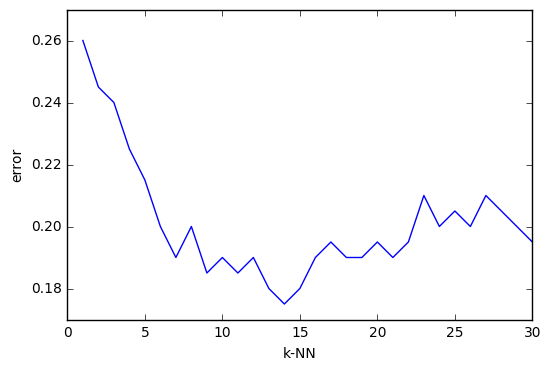

In [88]:
# Put your code here
import matplotlib.pyplot as plt

error=crossValidationkNN(traindata,trainlabels,30)
x=np.linspace(1,30,30)
plt.xlabel('k-NN')
plt.ylabel('error')
plt.plot(x,error[1:31])

Select the number of neighbors which minimizes the cross-validation error. What is the cross-validation error for this number of neighbors? <b>(10 points)</b>

In [89]:
# Put your code here
minCrossVal = 1
neighborVal = 0

for i in range(1,31):
    error = crossValidationkNN(traindata, trainlabels, i)
    for j in range(1,i+1):
        if error[j] < minCrossVal:
            minCrossVal = error[j]
            neighborVal = i

print "Number of Neighbors the minimizes cross-validation error: ", neighborVal
print "Cross-validation error for this number of neighbors: ", minCrossVal


Number of Neighbors the minimizes cross-validation error:  14
Cross-validation error for this number of neighbors:  0.175


Number of Neighbors the minimizes cross-validation error:  14

Cross-validation error for this number of neighbors:  0.175

Train a kNN model on the whole training data using the number of neighbors you found in the previous part of the question, and apply it to the test data. Is it higher or lower than the cross-validation error you found in the last part of the problem? **(10 points)**

In [90]:
# Put your code here
kNNtest = KNeighborsClassifier(n_neighbors = 14)
kNNneighbor = kNNtest.fit(traindata, trainlabels)

estTestlabels = kNNneighbor.predict(testdata)

print "Classifier error of test data: ", classifierError(testlabels, estTestlabels)

Classifier error of test data:  0.214


Classifier error of test data:  0.214

It is higher than the cross-validation error we found in the previous part of the problem.

### Problem 3: Detecting Cancer with SVMs and Logistic Regression (45 points)

We consider the [Breast Cancer Wisconsin Data Set](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29) from 
W.N. Street, W.H. Wolberg and O.L. Mangasarian. Nuclear feature extraction for breast tumor diagnosis. IS&T/SPIE 1993 International Symposium on Electronic Imaging: Science and Technology, volume 1905, pages 861-870, San Jose, CA, 1993. 

The authors diagnosed people by characterizing 3 cell nuclei per person extracted from the breast (pictures [here](http://web.archive.org/web/19970225174429/http://www.cs.wisc.edu/~street/images/)), each with 10 features (for a 30-dimensional feature space):

1. radius (mean of distances from center to points on the perimeter) 

2. texture (standard deviation of gray-scale values) 

3. perimeter 

4. area 

5. smoothness (local variation in radius lengths) 

6. compactness (perimeter^2 / area - 1.0) 

7. concavity (severity of concave portions of the contour) 

8. concave points (number of concave portions of the contour) 

9. symmetry 

10. fractal dimension ("coastline approximation" - 1)

and classified the sample into one of two classes: Malignant ($+1$) or Benign ($-1$). You can read the original paper for more on what these features mean.

You will be attempting to classify if a sample is Malignant or Benign using Support Vector Machines, as well as Logistic Regression. Since we don't have all that much data, we will use 10-fold cross-validation to tune our parameters for our SVMs and Logistic Regression. We use 90% of the data for training, and 10% for testing.

You will be experimenting with SVMs using Gaussian RBF kernels through sklearn.svm.SVC, linear SVMs through sklearn.svm.LinearSVC, and sklearn.linear_model.LogisticRegression for Logistic Regression. 

Your model selection will be done with cross-validation via sklearn.cross_validation's cross_val_score. This returns the accuracy for each fold, i.e. the fraction of samples classified correctly. Thus, the cross-validation error is simply 1-mean(cross_val_score).

First, we load the data. We will use scikit-learn's train test split function to split the data. The data is scaled for reasons outlined <a href="http://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf">here</a>. In short, it helps avoid some numerical issues and avoids some problems with certain features which are typically large affecting the SVM optimization problem unfairly compared to features which are typically small. 

In [69]:
from sklearn.cross_validation import train_test_split

cancer = genfromtxt('Data/wdbc.csv', delimiter=',')

np.random.seed(seed=282017) # seed the RNG for repeatability
idx=np.random.permutation(cancer.shape[0])
cancer=cancer[idx]

cancer_features=cancer[:,1:]
cancer_labels=cancer[:,0]

#The training data is in data_train with labels label_train. 
# The test data is in data_test with labels label_test.
data_train, data_test, label_train, label_test = train_test_split(cancer_features,cancer_labels,test_size=0.1,random_state=292017)

# Rescale the training data and scale the test data correspondingly
scaler=MinMaxScaler(feature_range=(-1,1))
data_train=scaler.fit_transform(data_train) #Note that the scaling is determined solely via the training data!
data_test=scaler.transform(data_test)

The soft margin linear SVM is tuned based on a parameter $C$, which controls how much points can be violating the margin (this isn't the same $C$ as in the notes, though it serves the same function; see the [scikit-learn documentation](http://scikit-learn.org/stable/modules/svm.html#svc) for details). 

Use cross-validation to select a value of $C$ for a linear SVM (sklearn.svm.LinearSVC) by varying $C$ from $2^{-5},2^{-4},\ldots,2^{15}$. 

Which value of $C$ would you choose, and why? What is the corresponding cross-validation error? <b>(10 points)</b>

In [71]:
#Put your code here
from sklearn import svm
from sklearn import model_selection

old_avg = 0
C = 0

c_matrix = np.zeros((21,0))

for i in range (-5,16):
    linSVM = svm.LinearSVC(C=(2**i))
    linSVM.fit(data_train, label_train)
    
    c_estimator = model_selection.cross_val_score(linSVM, data_train, label_train, cv=10)
    
    n_avg = np.average(c_estimator)
    
    if n_avg > old_avg:
        C = i
        old_avg = n_avg
        c_matrix[i] = n_avg
        
print "C value to choose with lowest cross-validation error: ", 2**C
print "Cross Validation error corresponding to value of C: ", 1 - old_avg

 C value to choose with lowest cross-validation error:  0.125
Cross Validation error corresponding to value of C:  0.027149321267


C value to choose with lowest cross-validation error:  0.125

Cross Validation error corresponding to value of C:  0.027149321267

You will now experiment with using kernels in an SVM, particularly the Gaussian RBF kernel (in sklearn.svm.SVC). The SVM has two parameters to tune in this case: $C$ (as before), and $\gamma$, which is a parameter in the RBF. 

Use cross-validation to select parameters $(C,\gamma)$ by searching varying $(C,\gamma)$ over $C=2^{-5},2^{-4},\ldots,2^{15}$ and $\gamma=2^{-15},\ldots,2^{3}$ [So, you will try about 400 parameter choices]. Out of these, which $(C,\gamma)$ parameters would you choose? What is the corresponding cross-validation error? 

This procedure is known as a *grid search*.We are using a fairly coarse grid for this problem, but one could use a finer grid once the rough range of good parameters is known (rather than starting with a fine grid, which would waste a lot of time). <b>(10 points)</b>

In [94]:
# Put your code here
from sklearn import svm
from sklearn import model_selection

old_avg = 0
C = 0
G = 0

cg_matrix = np.zeros((21,18))

for i in range (-5,16):
    for j in range(-15, 4):
        
        linSVM = svm.SVC(C=(2**i), kernel = 'rbf', gamma = (2**j))
        linSVM.fit(data_train, label_train)

        c_estimator = model_selection.cross_val_score(linSVM, data_train, label_train, cv=10)

        n_avg = np.average(c_estimator)

        if n_avg > old_avg:
            C = i
            old_avg = n_avg
            G = j
            cg_matrix[i, j] = n_avg

print "C value to choose with lowest cross-validation error: ", 2**C
print "Gamma value to choose with the lowest cross-validation error: ", 2**G
print "Cross Validation error corresponding to value of C and G: ", 1 - old_avg

C value to choose with lowest cross-validation error:  8
Gamma value to choose with the lowest cross-validation error:  0.125
Cross Validation error corresponding to value of C and G:  0.0194570135747


C value to choose with lowest cross-validation error:  8

Gamma value to choose with the lowest cross-validation error:  0.125

Cross Validation error corresponding to value of C and G:  0.0194570135747

As stated in a footnote in the notes, Logistic Regression normally has a regularizer parameter to promote stability. Scikit-learn calls this parameter $C$ (which is like $\lambda^{-1}$ in the notes); see the [LibLinear](http://www.csie.ntu.edu.tw/~cjlin/papers/liblinear.pdf) documentation for the exact meaning of $C$. 

Use cross-validation to select a value of $C$ for logistic regression (sklearn.linear_model.LogisticRegression) by varying $C$ from $2^{-14},2^{-4},\ldots,2^{14}$. You may optionally make use of sklearn.model_selection.GridSearchCV, or write the search by hand (as before). 

Which value of $C$ would you choose? What is the corresponding cross-validation error? **(5 points)**

In [97]:
#Put your code here
from sklearn import linear_model
from sklearn import model_selection

old_avg = 0
C = 0

c_matrix = np.zeros((21,0))

for i in range (-14,15):
    LogR = linear_model.LogisticRegression(C=(2**i))
    LogR.fit(data_train, label_train)
    
    c_estimator = model_selection.cross_val_score(LogR, data_train, label_train, cv=10)
    
    n_avg = np.average(c_estimator)
    
    if n_avg > old_avg:
        C = i
        old_avg = n_avg
        c_matrix[i] = n_avg
        
print "C value to choose with lowest cross-validation error: ", 2**C
print "Cross Validation error corresponding to value of C: ", 1 - old_avg

C value to choose with lowest cross-validation error:  2
Cross Validation error corresponding to value of C:  0.027149321267


C value to choose with lowest cross-validation error:  2

Cross Validation error corresponding to value of C:  0.027149321267

Based on the classifiers you selected thus far for Linear SVM, SVM + Gaussian RBF and Logistic Regression, which classifier would you pick? Make sure to take into account error, the application and computational considerations. **(5 points)**

I would choose the SVM + Gaussian RBF classifier. Although it required more parameters (C and gamma), and took a longer time to generate a result, its cross validation error was significantly lower than that of the other classifiers. In the case of cancer detection, it is crucial to get the lowest error possible, and therefore SVM + Gaussian RBF is the best bet.

Train the classifier selected above on the whole training set. Then, estimate the prediction error using the test set. What is your estimate of the prediction error? How does it compare to the cross-validation error?  <b>(10 points)</b>

In [98]:
#Put your code here
from sklearn import svm
RBFclassifier =svm.SVC(C=(8),kernel='rbf',gamma=0.125)
RBFclassifier.fit(data_train,label_train)
estimatedValLabels = RBFclassifier.predict(data_test)
error = classifierError(label_test,estimatedValLabels)
print'Test Error: ',error

Test Error:  0.0175438596491


Estimated prediction error is  0.0175438596491

This is lower than the cross-validation error we found.

Do you think the 0,1-loss is appropriate performance measure to report, in this case? If so, why? If not, how would you measure performance? **(5 points)**

0,1 - loss is appropriate because there are only two valid cases in terms of cancer detection. Either the cell nuclei can be malignant or benign; there is no intermediary state. Therefore if there is even one indication that a cell nuclei is malignant, the whole cell nuclei should just be labelled malignant for precautionary measures.